Plan / étapes du projet

Charger le dataset LaLonde

EDA rapide (statistiques, distribution de re78, proportion traité)

Construire un DAG (documenter hypothèses)

Estimer Propensity Score (logistic regression)

Vérifier overlap (histogrammes / densities des PS pour T=1 vs T=0)

Estimation ATE via :

Matching (nearest neighbour on PS) + bootstrap pour IC

IPW (weights) — optionnel

Causal Forest (EconML CausalForestDML) pour ATE & CATE

Diagnostics : balance covariates (SMD) avant/après matching, sensibilité

Interpréter & rédiger conclusions (business recommendation)

# Mini-projet Causal ML — LaLonde

**Objectif :** Estimer l'impact causal (ATE & CATE) d'un programme de formation (traitement `treat`) sur le revenu en 1978 (`re78`) à partir du dataset LaLonde (Matching::lalonde).

This notebook follows the requested plan and includes explanations and runnable code.

**Remarque :** si `econml` n'est pas installé, la section CausalForest sera indiquée et sautée.

In [15]:
# Imports et fonctions utilitaires
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Standardized Mean Difference (SMD).

C’est un indicateur très important en causal ML pour vérifier si les groupes :

- traités (T=1)
- non-traités (T=0)

sont comparables après un ajustement (matching, IPW, etc.).

- SMD doit devenir petit (< 0.1) → groupes bien équilibrés.

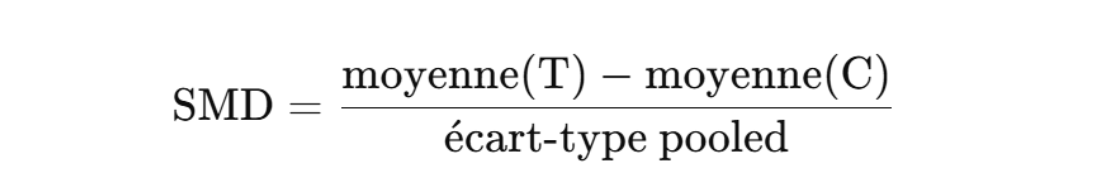

In [16]:
def smd(series_t, series_c):
    s_t = np.array(series_t, dtype=float)
    s_c = np.array(series_c, dtype=float)
    num = s_t.mean() - s_c.mean()
    denom = np.sqrt((s_t.var(ddof=1) + s_c.var(ddof=1)) / 2)
    if denom == 0:
        return 0.0
    return num/denom

print('Environment ready')

Environment ready


## 1) Charger le dataset LaLonde

Nous utilisons la version fournie par `statsmodels` (Matching::lalonde en R).

In [17]:
# Charger LaLonde depuis statsmodels datasets
df = pd.read_csv('lalonde.csv')
df.columns = [c.lower() for c in df.columns]
print('Colonnes disponibles:', df.columns.tolist())


Colonnes disponibles: ['unnamed: 0', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']


In [20]:
df['treat'].value_counts()

treat
0    429
1    185
Name: count, dtype: int64

In [5]:
display(df.head())


,unnamed: 0,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 2) EDA rapide

Statistiques descriptives, distribution de `re78`, proportion traité.

In [32]:
df.isna().sum()

unnamed: 0    0
treat         0
age           0
educ          0
black         0
hispan        0
married       0
nodegree      0
re74          0
re75          0
re78          0
ps            0
dtype: int64

In [18]:
# Statistiques descriptives
display(df.describe(include='all').T)


,count,mean,std,min,25%,50%,75%,max
unnamed: 0,614.0,307.500000,177.390811,1.0,154.250000,307.5000,460.75000,614.00
treat,614.0,0.301303,0.459198,0.0,0.000000,0.0000,1.00000,1.00
age,614.0,27.363192,9.881187,16.0,20.000000,25.0000,32.00000,55.00
educ,614.0,10.268730,2.628325,0.0,9.000000,11.0000,12.00000,18.00
black,614.0,0.395765,0.489413,0.0,0.000000,0.0000,1.00000,1.00
hispan,614.0,0.117264,0.321997,0.0,0.000000,0.0000,0.00000,1.00
married,614.0,0.415309,0.493177,0.0,0.000000,0.0000,1.00000,1.00
nodegree,614.0,0.630293,0.483119,0.0,0.000000,1.0000,1.00000,1.00
re74,614.0,4557.546569,6477.964479,0.0,0.000000,1042.3300,7888.49825,35040.07
re75,614.0,2184.938207,3295.679043,0.0,0.000000,601.5484,3248.98750,25142.24



Proportion traité (treat=1):
treat
0    0.698697
1    0.301303
Name: proportion, dtype: float64


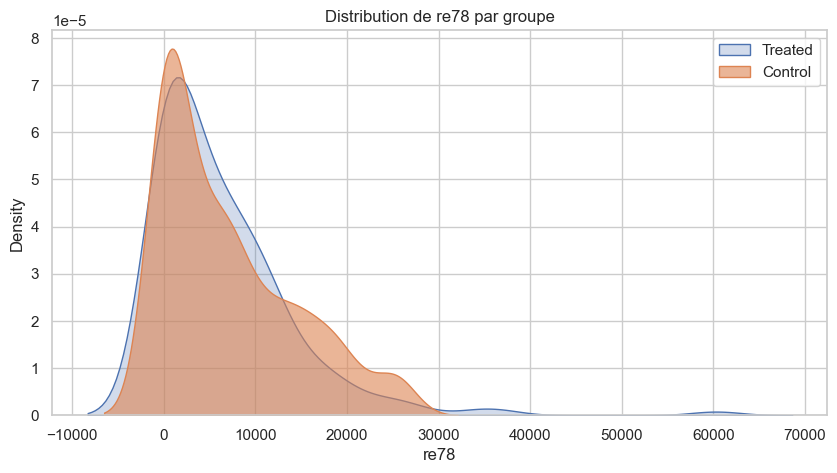

In [19]:

print('\nProportion traité (treat=1):')
print(df['treat'].value_counts(normalize=True))

# Distribution re78 par groupe
plt.figure(figsize=(10,5))
sns.kdeplot(df.loc[df['treat']==1,'re78'], label='Treated', fill=True)
sns.kdeplot(df.loc[df['treat']==0,'re78'], label='Control', fill=True, alpha=0.6)
plt.title('Distribution de re78 par groupe')
plt.legend()
plt.show()

## 3) Construire un DAG 



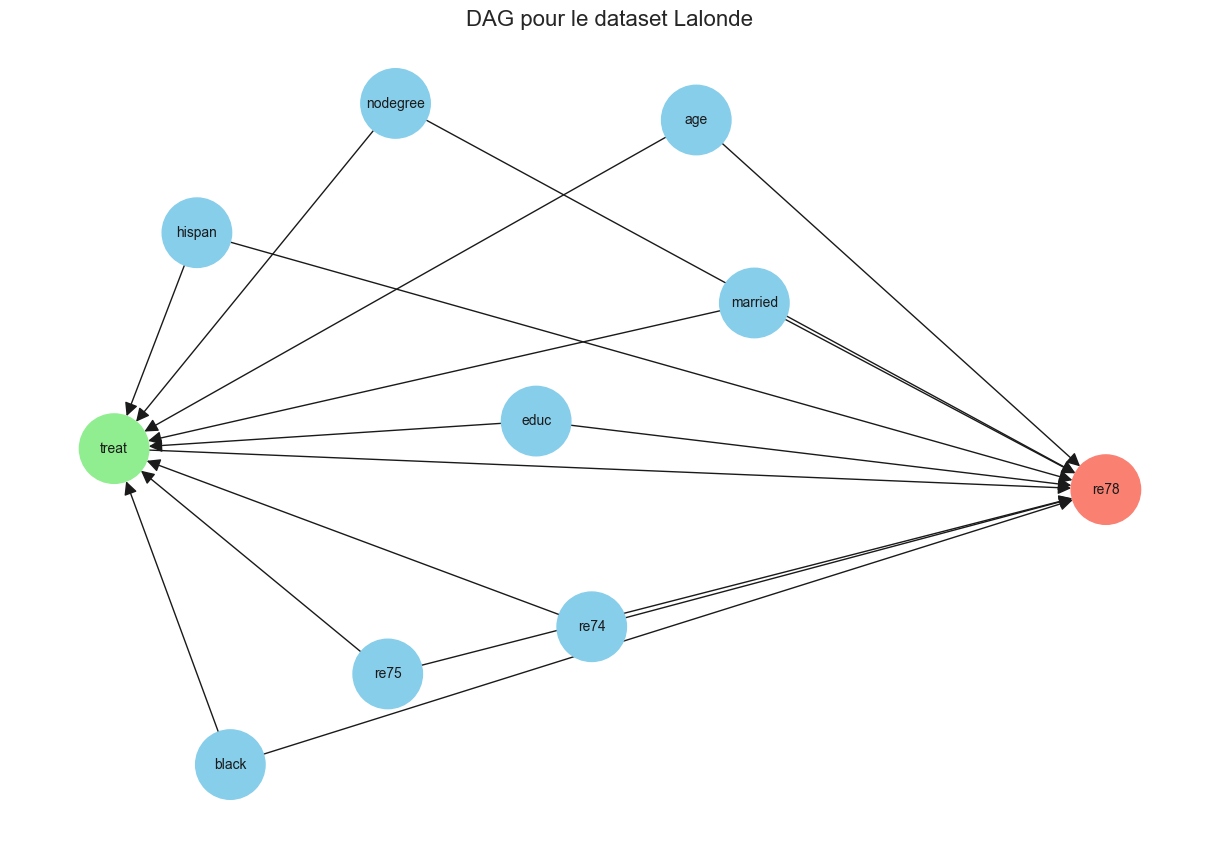

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Créer un graphe dirigé
G = nx.DiGraph()

# Noeuds
confounders = ['age','educ','black','hispan','married','nodegree','re74','re75']
treatment = 'treat'
outcome = 're78'

# Ajouter les noeuds avec attributs pour couleur
for c in confounders:
    G.add_node(c, color='skyblue')
G.add_node(treatment, color='lightgreen')
G.add_node(outcome, color='salmon')

# Arêtes confounders -> treatment et confounders -> outcome
for c in confounders:
    G.add_edge(c, treatment)
    G.add_edge(c, outcome)

# Arête treatment -> outcome
G.add_edge(treatment, outcome)

# Dessiner le graphe
colors = [G.nodes[n]['color'] for n in G.nodes()]
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)  # positions automatiques
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, font_size=10, arrowsize=20)
plt.title("DAG pour le dataset Lalonde", fontsize=16)
plt.show()


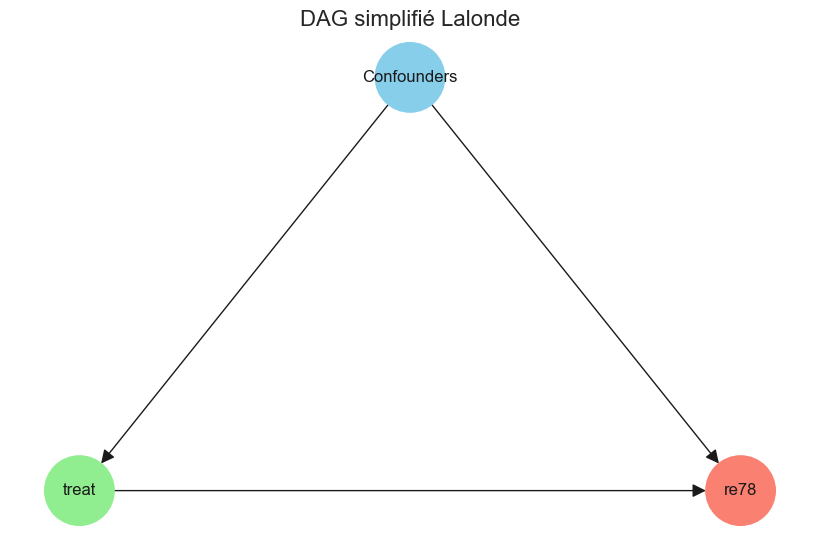

In [30]:

# Noeuds
G.add_node('Confounders', color='skyblue')
G.add_node('treat', color='lightgreen')
G.add_node('re78', color='salmon')

# Arêtes
G.add_edge('Confounders', 'treat')
G.add_edge('Confounders', 're78')
G.add_edge('treat', 're78')

# Positions forcées pour layout gauche → droite
pos = {
    'treat': (0, 0),          # à gauche
    'Confounders': (0.5, 0.5), # au centre en haut
    're78': (1, 0)             # à droite
}

# Dessiner le graphe
colors = [G.nodes[n]['color'] for n in G.nodes()]
plt.figure(figsize=(8,5))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, font_size=12, arrowsize=20)
plt.title("DAG simplifié Lalonde", fontsize=16)
plt.show()



## 4) Estimer le Propensity Score (régression logistique)

- Nous estimons `ps = P(treat=1 | C)`.

Dans les études observationnelles, les groupes traités et non traités peuvent être très différents. On utilise le PS pour équilibrer les groupes sur leurs covariables, comme si on avait fait une expérimentation aléatoire.


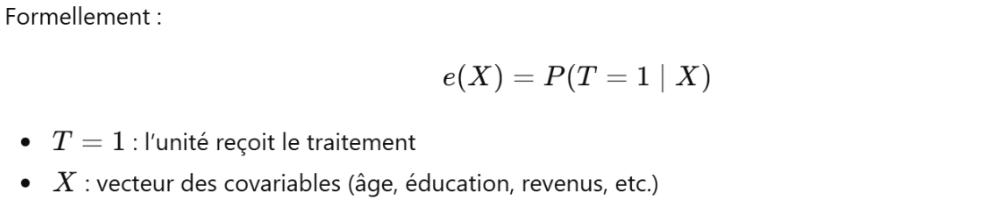

In [33]:
covariates = ['age','educ','black','hispan','married','nodegree','re74','re75'] #covariates
X = df[covariates]
y = df['treat'] # traitement

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(Xs, y)
df['ps'] = ps_model.predict_proba(Xs)[:,1]

display(df[['treat','ps'] + covariates].head())


,treat,ps,age,educ,black,hispan,married,nodegree,re74,re75
0,1,0.630911,37,11,1,0,1,1,0.0,0.0
1,1,0.222319,22,9,0,1,0,1,0.0,0.0
2,1,0.674664,30,12,1,0,0,0,0.0,0.0
3,1,0.770028,27,11,1,0,0,1,0.0,0.0
4,1,0.698265,33,8,1,0,0,1,0.0,0.0


## 5) Vérifier overlap (densités des PS)

Tracer les densités de PS pour T=1 vs T=0.

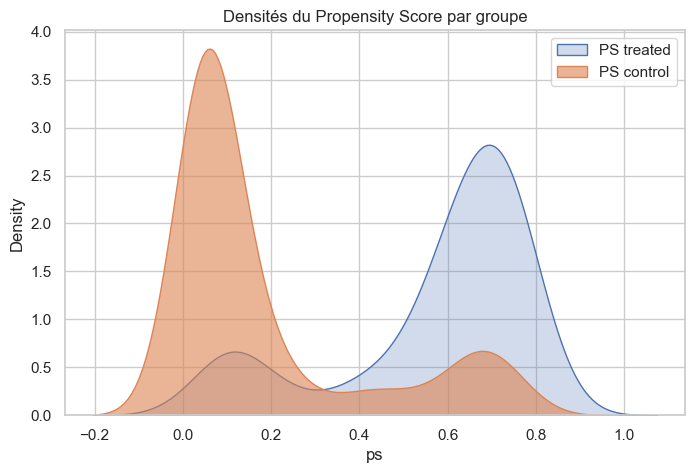

In [35]:
plt.figure(figsize=(8,5))
sns.kdeplot(df.loc[df['treat']==1,'ps'], label='PS treated', fill=True)
sns.kdeplot(df.loc[df['treat']==0,'ps'], label='PS control', fill=True, alpha=0.6)
plt.title('Densités du Propensity Score par groupe'); plt.legend(); plt.show()



In [39]:

df.groupby('treat')['ps'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,0.183355,0.227426,0.010069,0.041138,0.079793,0.194288,0.782358
1,185.0,0.574773,0.217640,0.026855,0.526736,0.651709,0.722241,0.844154


| Groupe       | PS moyen | Interprétation                                                                   |
| ------------ | -------- | -------------------------------------------------------------------------------- |
| Contrôle (0) | 0.18     | La majorité des contrôles ont une faible probabilité d’avoir reçu le traitement. |
| Traité (1)   | 0.57     | Les individus traités ont en moyenne un PS plus élevé.                           |


## 6) Estimation ATE via Matching (nearest neighbour on PS) + Bootstrap CI

In [40]:
# Séparation des groupes traité et contrôle
treated = df[df['treat']==1].reset_index(drop=True)
control = df[df['treat']==0].reset_index(drop=True)

# Matching 1-NN sur le propensity score
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['ps']]) #NearestNeighbors recherche pour chaque traité le contrôle avec le Propensity Score le plus proche.
dist, idx = nn.kneighbors(treated[['ps']])
matched_control = control.iloc[idx.flatten()].reset_index(drop=True)

# Calcul de l'ATE après matching
ate_matched = (treated['re78'].values - matched_control['re78'].values).mean()
print('ATE (matching) =', ate_matched)

# Bootstrap pour l'intervalle de confiance de l'ATE
def bootstrap_ate_pairs(treated_vals, control_vals, n_boot=2000, seed=0):
    rng = np.random.RandomState(seed)
    n = len(treated_vals)
    ates = []
    for i in range(n_boot):
        ids = rng.randint(0, n, n)
        ates.append((treated_vals[ids] - control_vals[ids]).mean())
    return np.percentile(ates, [2.5,97.5]), np.mean(ates)

ci, ate_mean = bootstrap_ate_pairs(treated['re78'].values, matched_control['re78'].values, n_boot=2000)
print('Bootstrap ATE mean:', ate_mean, 'CI(2.5,97.5):', ci)


ATE (matching) = 1227.2391494594592
Bootstrap ATE mean: 1229.5505097425132 CI(2.5,97.5): [-165.13571811 2700.01379744]


✅ Les résultats du matching et bootstrap sont cohérants 1227 et 1229


### IPW (Inverse Probability Weighting) — optionnel

Calcul des poids stabilisés et estimation ATE pondéré.

In [41]:
df['w'] = np.where(df['treat']==1, 1/df['ps'], 1/(1-df['ps']))
p_t = df['treat'].mean()
df['w_stab'] = np.where(df['treat']==1, p_t/df['ps'], (1-p_t)/(1-df['ps']))

ate_ipw = (df[df['treat']==1]['re78'] * df[df['treat']==1]['w_stab']).sum() / df[df['treat']==1]['w_stab'].sum() \
        - (df[df['treat']==0]['re78'] * df[df['treat']==0]['w_stab']).sum() / df[df['treat']==0]['w_stab'].sum()
print('ATE (IPW stabilized) =', ate_ipw)


ATE (IPW stabilized) = 232.42121949850025


## 7) Diagnostics : Covariate balance (SMD) avant / après matching

In [12]:
print('SMD before matching:')
for col in covariates:
    val = smd(df[df['treat']==1][col], df[df['treat']==0][col])
    print(f'{col}: {val:.3f}')

print('\nSMD after matching:')
for col in covariates:
    val = smd(treated[col], matched_control[col])
    print(f'{col}: {val:.3f}')


SMD before matching:
age: -0.242
educ: 0.045
black: 1.668
hispan: -0.277
married: -0.719
nodegree: 0.235
re74: -0.596
re75: -0.287

SMD after matching:
age: 0.106
educ: -0.007
black: 0.015
hispan: -0.064
married: 0.056
nodegree: 0.012
re74: -0.041
re75: -0.046


## 8) Causal Forest (EconML) — ATE & CATE
Utilisation de `econml.dml.CausalForestDML`. Si absent, instructions d'installation s'affichent.

In [64]:
econml_available = False
try:
    from econml.dml import CausalForestDML
    from sklearn.ensemble import RandomForestRegressor
    econml_available = True
except Exception as e:
    print('econml import failed:', e)
    print('\nTo install econml, run: pip install econml --no-binary econml')

if econml_available:
    print('EconML available. Fitting CausalForestDML...')
    
    T = df['treat'].values
    Y = df['re78'].values
    W = df[covariates].values
    
    est = CausalForestDML(
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_y=RandomForestRegressor(n_estimators=200, min_samples_leaf=5),
        n_estimators=200,
        random_state=123
    )
    
    est.fit(Y, T, X=W)
    
    ate_cf = est.ate(X=W)
    print('CausalForest ATE:', ate_cf)
    
    cates = est.effect(X=W[:10])
    print('First 10 CATEs:', cates)

else:
    print('Skipping CausalForest section.')


EconML available. Fitting CausalForestDML...
CausalForest ATE: 965.0124588960214
First 10 CATEs: [2365.58665091  883.87879567 2456.36652853 4040.80331715 2399.79064117
  366.0104439   -95.90685394 3442.40746533 -542.35808989 2798.11082658]


In [56]:
df['CATE'] = cates_all
df[['treat','re78','CATE']].head(10)


,treat,re78,CATE
0,1,9930.0460,2887.158818
1,1,3595.8940,776.806932
2,1,24909.4500,2958.090089
3,1,7506.1460,3952.957997
4,1,289.7899,2751.928309
5,1,4056.4940,111.288656
6,1,0.0000,486.911556
7,1,8472.1580,3788.558456
8,1,2164.0220,-493.760160
9,1,12418.0700,2979.299643


Ligne 0 → traitement = 1, revenu = 9930, effet estimé = 2887
→ On estime que si cette personne n’avait pas reçu le traitement, son revenu aurait été ~2887 inférieur.

Les valeurs négatives de CATE signifient que pour certains individus, le traitement aurait réduit leur outcome par rapport au contrôle.

In [ ]:
df.groupby('nodegree')['CATE'].mean()

nodegree
0    1110.702608
1    1055.816170
Name: CATE, dtype: float64

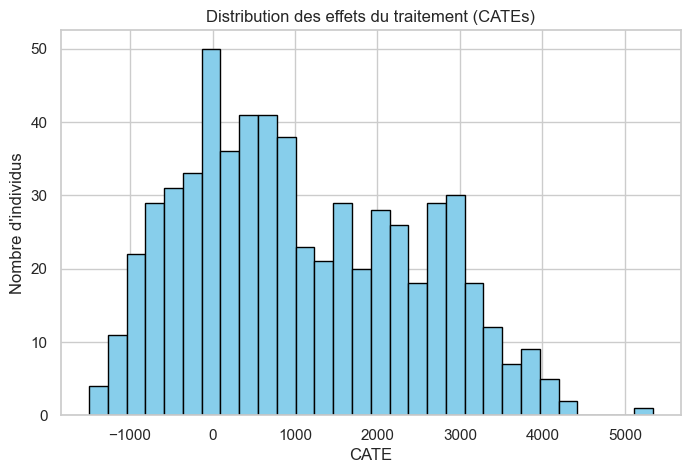

In [51]:

plt.figure(figsize=(8,5))
plt.hist(df['CATE'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution des effets du traitement (CATEs)")
plt.xlabel("CATE")
plt.ylabel("Nombre d'individus")
plt.show()

In [58]:
import numpy as np

# Calculer l'histogramme
counts, bin_edges = np.histogram(df['CATE'], bins=30)

# Afficher les résultats
for i in range(len(counts)):
    print(f"Bin {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f} : {counts[i]} individus")




Bin -1498.18 - -1270.40 : 4 individus
Bin -1270.40 - -1042.62 : 11 individus
Bin -1042.62 - -814.84 : 22 individus
Bin -814.84 - -587.06 : 29 individus
Bin -587.06 - -359.28 : 31 individus
Bin -359.28 - -131.51 : 33 individus
Bin -131.51 - 96.27 : 50 individus
Bin 96.27 - 324.05 : 36 individus
Bin 324.05 - 551.83 : 41 individus
Bin 551.83 - 779.61 : 41 individus
Bin 779.61 - 1007.39 : 38 individus
Bin 1007.39 - 1235.17 : 23 individus
Bin 1235.17 - 1462.94 : 21 individus
Bin 1462.94 - 1690.72 : 29 individus
Bin 1690.72 - 1918.50 : 20 individus
Bin 1918.50 - 2146.28 : 28 individus
Bin 2146.28 - 2374.06 : 26 individus
Bin 2374.06 - 2601.84 : 18 individus
Bin 2601.84 - 2829.62 : 29 individus
Bin 2829.62 - 3057.39 : 30 individus
Bin 3057.39 - 3285.17 : 18 individus
Bin 3285.17 - 3512.95 : 12 individus
Bin 3512.95 - 3740.73 : 7 individus
Bin 3740.73 - 3968.51 : 9 individus
Bin 3968.51 - 4196.29 : 5 individus
Bin 4196.29 - 4424.07 : 2 individus
Bin 4424.07 - 4651.84 : 0 individus
Bin 4651.84 

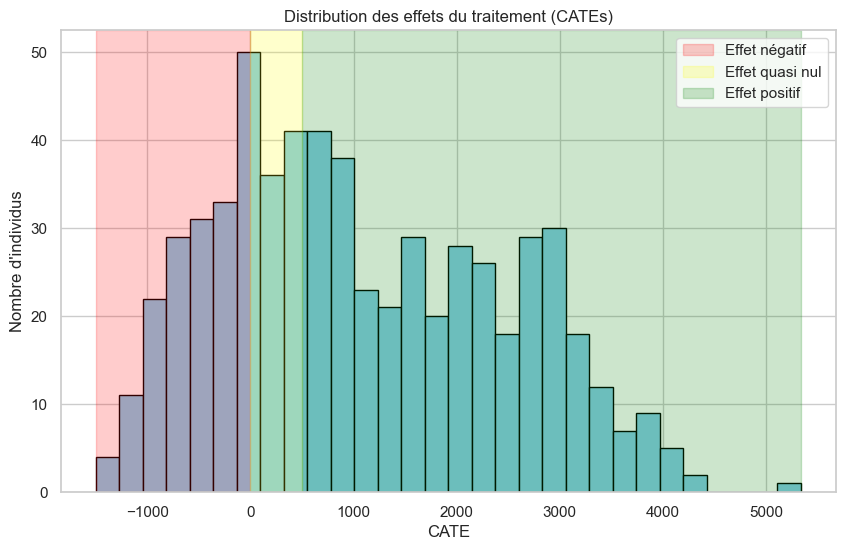

In [59]:
import matplotlib.pyplot as plt

# Récupérer les CATEs
cates = df['CATE']

# Couleurs selon effet
colors = ['red' if x < 0 else 'green' for x in cates]

plt.figure(figsize=(10,6))
plt.hist(cates, bins=30, color='skyblue', edgecolor='black')

# Ajouter des zones colorées
plt.axvspan(cates.min(), 0, color='red', alpha=0.2, label='Effet négatif')
plt.axvspan(0, 500, color='yellow', alpha=0.2, label='Effet quasi nul')
plt.axvspan(500, cates.max(), color='green', alpha=0.2, label='Effet positif')

plt.title("Distribution des effets du traitement (CATEs)")
plt.xlabel("CATE")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()


In [60]:
# Définir les zones
negatif = df[df['CATE'] < 0]
quasi_neutre = df[(df['CATE'] >= 0) & (df['CATE'] <= 500)]
positif = df[df['CATE'] > 500]

# Compter les individus
print("Nombre d'individus avec effet négatif :", len(negatif))
print("Nombre d'individus avec effet quasi neutre :", len(quasi_neutre))
print("Nombre d'individus avec effet positif :", len(positif))

# Pourcentage
total = len(df)
print("Pourcentage effet négatif: {:.1f}%".format(len(negatif)/total*100))
print("Pourcentage effet quasi neutre: {:.1f}%".format(len(quasi_neutre)/total*100))
print("Pourcentage effet positif: {:.1f}%".format(len(positif)/total*100))


Nombre d'individus avec effet négatif : 162
Nombre d'individus avec effet quasi neutre : 85
Nombre d'individus avec effet positif : 367
Pourcentage effet négatif: 26.4%
Pourcentage effet quasi neutre: 13.8%
Pourcentage effet positif: 59.8%


In [63]:
# Récupérer les individus avec effet positif
positive_effect_df = df[df['CATE'] > 500].reset_index(drop=True)

# Afficher le nombre d'individus et un aperçu
print("Nombre d'individus avec effet positif :", len(positive_effect_df))
positive_effect_df.head()


Nombre d'individus avec effet positif : 367


,unnamed: 0,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,ps,w,w_stab,CATE
0,1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.630911,1.585009,0.477568,2887.158818
1,2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.222319,4.498044,1.355274,776.806932
2,3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.674664,1.482219,0.446597,2958.090089
3,4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.770028,1.298653,0.391288,3952.957997
4,5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698265,1.432121,0.431502,2751.928309


## 9) Sensibilité & limites

Vérifie ignorability, overlap et mentions les confounders non mesurés. Propose tests de refutation (DoWhy) si possible.

## 10) Interprétation & recommandations

- Présente les valeurs ATE/CI, interprète, recommande actions business (ex : cibler segments avec CATE élevé) et liste limitations.